In [50]:
# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [51]:
# 데이터 로드
file_path = "superstore_dataset.csv"  # 데이터 파일 경로
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# 불필요한 컬럼 제거
df = df.drop(columns=['Row ID', 'Order ID', 'Customer ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Country', 'City', 'State',
                      'Postal Code', 'Product Name', 'Product ID'])

# 날짜 형식 변환
df['Order Date'] = pd.to_datetime(df['Order Date'])

# 파생 변수 생성
df['Order Month'] = df['Order Date'].dt.month
df['Order Year'] = df['Order Date'].dt.year

# 원래 날짜 컬럼 제거
df = df.drop(columns=['Order Date'])

# 결측치 처리
df = df.dropna()

# 이상치 제거: IQR 방식 사용
def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    return data[(data[column] >= Q1 - 1.5 * IQR) & (data[column] <= Q3 + 1.5 * IQR)]

df = remove_outliers(df, 'Sales')
df = remove_outliers(df, 'Profit')


지역별 판매 및 이익 분석:
    Region        Sales      Profit
0  Central   95091.4404  11216.9376
1     East  116104.7900  19503.6842
2    South   72680.4480  11529.6173
3     West  176752.8375  28979.4454


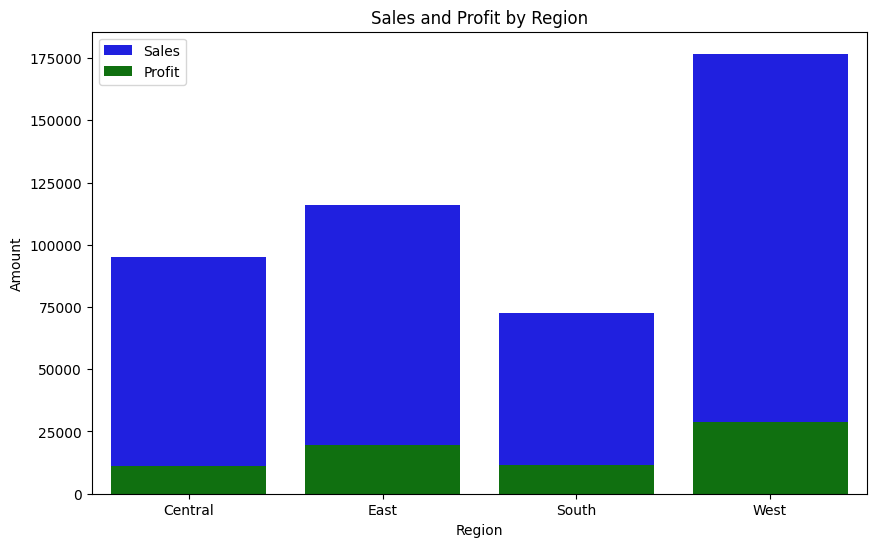

In [52]:
# EDA: 지역별 판매 및 이익 분석
region_sales_profit = df.groupby('Region')[['Sales', 'Profit']].sum().reset_index()
print("\n지역별 판매 및 이익 분석:")
print(region_sales_profit)

plt.figure(figsize=(10, 6))
sns.barplot(data=region_sales_profit, x='Region', y='Sales', color='blue', label='Sales')
sns.barplot(data=region_sales_profit, x='Region', y='Profit', color='green', label='Profit')
plt.title('Sales and Profit by Region')
plt.ylabel('Amount')
plt.legend()
plt.show()


카테고리 및 하위 카테고리별 이익 분석:
           Category Sub-Category      Profit
0         Furniture    Bookcases    865.1084
1         Furniture       Chairs   2065.4015
2         Furniture  Furnishings   8349.7644
3         Furniture       Tables    182.9600
4   Office Supplies   Appliances   4292.2392
5   Office Supplies          Art   5137.9678
6   Office Supplies      Binders   5500.4075
7   Office Supplies    Envelopes   3045.6669
8   Office Supplies    Fasteners    949.5182
9   Office Supplies       Labels   3276.0125
10  Office Supplies        Paper  16149.2133
11  Office Supplies      Storage   4953.2209
12  Office Supplies     Supplies    952.8074
13       Technology  Accessories   7806.9260
14       Technology     Machines    363.4205
15       Technology       Phones   7339.0500


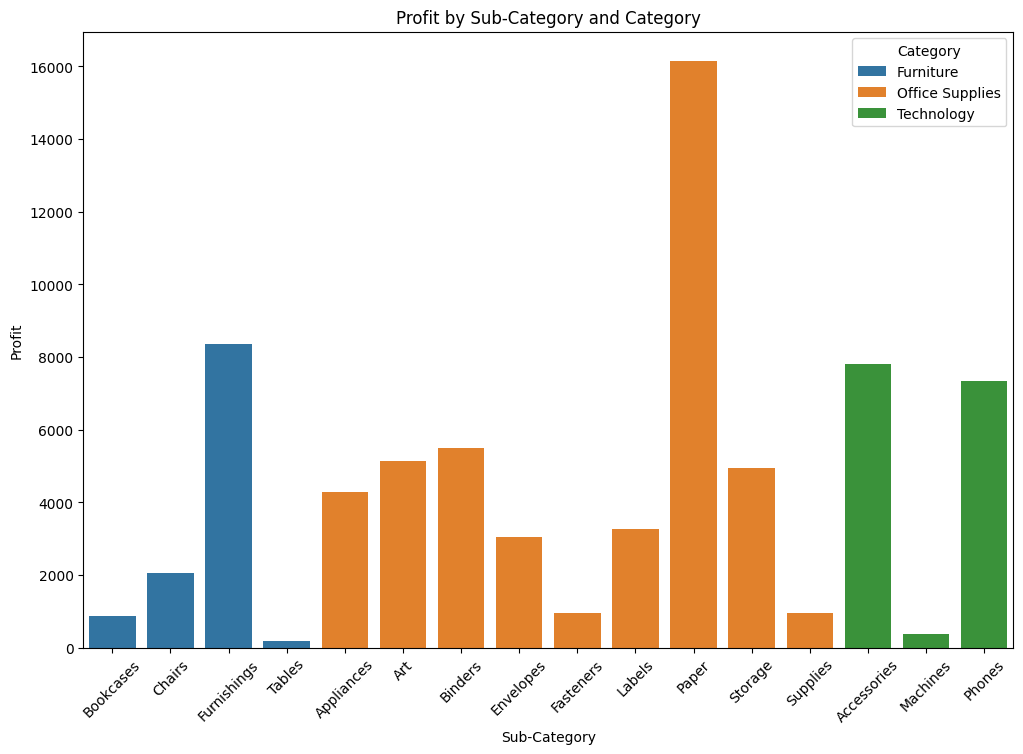

In [53]:
# EDA: 카테고리 및 하위 카테고리별 이익 분석
category_profit = df.groupby(['Category', 'Sub-Category'])['Profit'].sum().reset_index()
print("\n카테고리 및 하위 카테고리별 이익 분석:")
print(category_profit)

plt.figure(figsize=(12, 8))
sns.barplot(data=category_profit, x='Sub-Category', y='Profit', hue='Category', dodge=False)
plt.title('Profit by Sub-Category and Category')
plt.ylabel('Profit')
plt.xticks(rotation=45)
plt.show()

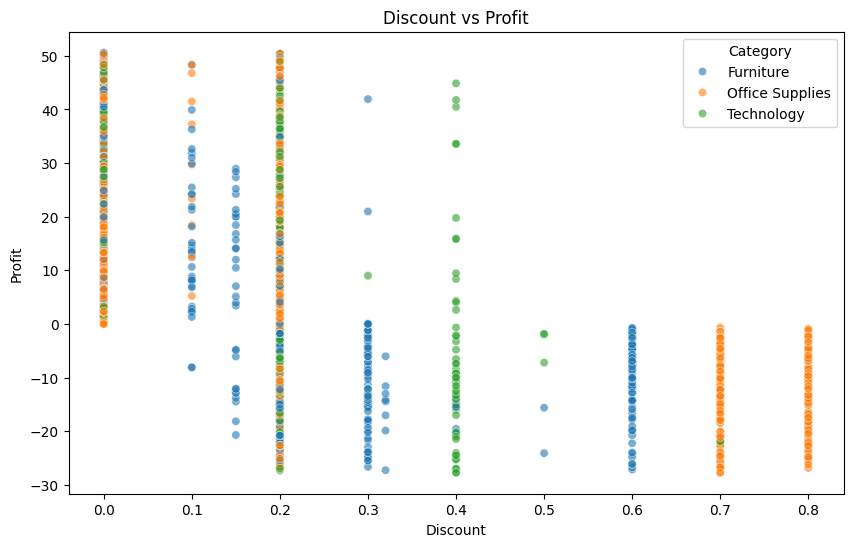

In [54]:
# EDA: 할인율과 이익의 관계 분석
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Discount', y='Profit', hue='Category', alpha=0.6)
plt.title('Discount vs Profit')
plt.xlabel('Discount')
plt.ylabel('Profit')
plt.show()


Random Forest Model:
MSE: 1663.07
R2: 0.74
Fitting 3 folds for each of 27 candidates, totalling 81 fits

Optimized Random Forest:
MSE: 1714.19
R2: 0.74


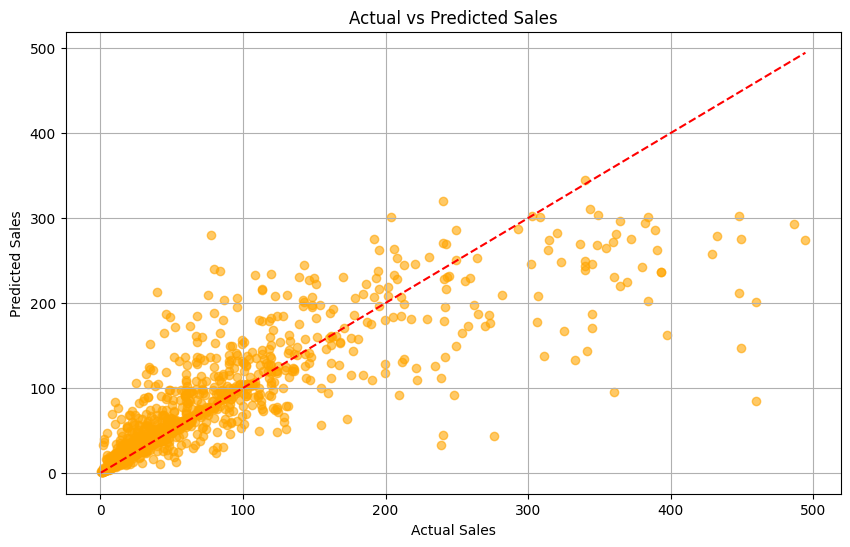

In [55]:
# 범주형 변수 인코딩
categorical_columns = ['Segment', 'Region', 'Category', 'Sub-Category']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# 모델링에 사용할 변수와 타겟 변수 선택
features = df.drop(columns=['Sales'])
target = df['Sales']

# 데이터 스케일링
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# 학습 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# 모델 1: 랜덤 포레스트
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# 랜덤 포레스트 평가
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"\nRandom Forest Model:\nMSE: {mse_rf:.2f}\nR2: {r2_rf:.2f}")

# 하이퍼파라미터 튜닝: 랜덤 포레스트
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,  # 교차 검증 fold 수를 5로 증가
    scoring='neg_mean_absolute_error',  # MAE 기반 평가
    verbose=1
)
grid_search.fit(X_train, y_train)

# 최적의 모델로 평가
best_rf_model = grid_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print(f"\nOptimized Random Forest:\nMSE: {mse_best_rf:.2f}\nR2: {r2_best_rf:.2f}")

# 결과 시각화: 실제 값 vs 예측 값
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best_rf, alpha=0.6, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.grid()
plt.show()